In [ ]:
## self written rrt

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import time1

image_counter = 1

cov_obs = np.array([[0.001,-0.000],[-0.000,0.015]])
cov_rob = np.array([[0.0001,-0.000],[-0.000,0.0015]])

move_obs = [0.2,0]

show_animation = True


class Node():

	def __init__(self,x,y):

		self.x = x
		self.y = y
		self.parent = None


class RRT():

	def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0,goal_sample_rate=20, max_iter=500):

		self.start = Node(start[0], start[1])
		self.end = Node(goal[0], goal[1])
		self.minrand = rand_area[0]
		self.maxrand = rand_area[1]
		self.expand_dis = expand_dis
		self.goal_sample_rate = goal_sample_rate
		self.max_iter = max_iter
		self.obstacle_list = obstacle_list

	def Planning(self, animation=True):

		self.node_list = [self.start]

		while True:

			if random.randint(0,100) > self.goal_sample_rate :
				rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
			else :
				rnd = [self.end.x, self.end.y]

			## find the nearest node out of the random sampled node to the previous node in node_list
			nind = self.get_nearest_list_index(self.node_list, rnd)

			## expand the search tree
			nearest_node = self.node_list[nind]

			theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)

			new_node = copy.deepcopy(nearest_node)
			new_node.x += self.expand_dis*math.cos(theta_to_new_node)
			new_node.y += self.expand_dis*math.sin(theta_to_new_node)
			new_node.parent = nind

			## lets check the sequence length upto this node which will be used to grow the covariance
			sequence = [[new_node.x, new_node.y]]
			last_index = new_node.parent
			while self.node_list[last_index].parent is not None:
				node = self.node_list[last_index]
				sequence.append([node.x, node.y])
				last_index = node.parent
			sequence.append([self.start.x, self.start.y])

			sequence_length = len(sequence)

			## check if the new node is in collision
			if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
				continue

			self.node_list.append(new_node)
			print(len(self.node_list))

			#$ check if goal as at the next node
			dx = new_node.x - self.end.x
			dy = new_node.y - self.end.y
			d = math.sqrt(dx**2 + dy**2)

			if d <= self.expand_dis:
				print("Goal!")
				break

			if animation:
				self.draw_graph(sequence_length, rnd)

		path = [[self.end.x, self.end.y]]
		last_index = len(self.node_list) - 1
		while self.node_list[last_index].parent is not None:
			node = self.node_list[last_index]
			path.append([node.x, node.y])
			last_index = node.parent
		path.append([self.start.x, self.start.y])

		nodelist = self.node_list

		return path, nodelist

	def get_nearest_list_index(self, node_list, rnd):

		distance_list = [(node.x - rnd[0])**2 + (node.y - rnd[1])**2 for node in node_list]
		minind = distance_list.index(min(distance_list))
		return minind

	def __collision_check(self, node, obstacle_list, sequence_length):


		for (ox, oy, size) in obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			dx = ox - node.x
			dy = oy - node.y
			d = math.sqrt(dx**2 + dy**2)
			x_o  = np.array([ox,oy])
			x_r = np.array([node.x,node.y])
			cov_robo = sequence_length*cov_rob
			bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
			print(d, bhatta_dist)
			if np.abs(bhatta_dist) <= 100:
				return False
		return True

	def draw_graph(self, sequence_length=0, rnd=None):

		global image_counter

		# plt.clf()
		# if rnd is not None:
		# 	plt.plot(rnd[0], rnd[1],'^k')
		# 	x_r = np.array([rnd[0],rnd[1]])
		# 	cov_robo = sequence_length*cov_rob
		# 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
		# 	plt.plot(xr,yr,'-r')
		# 	# time.sleep(2)

		for node in self.node_list:
			if node.parent is not None:
				plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
		for (ox, oy, size) in self.obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			x_o = np.array([ox,oy])
			x,y = draw_cov(x_o, cov_obs, p=0.95)
			# plt.plot(x,y,'-b')
			plt.plot(ox, oy, "s", color='black', markersize=size*30)


		plt.plot(self.start.x, self.start.y, "xr")
		plt.plot(self.end.x, self.end.y, "xr")
		plt.axis([-15, 15, -15, 15])
		plt.grid(True)
		plt.savefig('image%04d'%image_counter)
		image_counter += 1
		plt.pause(0.01)


def main(gx=6.0, gy=12.0):
	#print("start " + __file__)

	global image_counter

	obstacleList = [
		(5, 5, 0.25),
		(3, 6, 0.5),
		(3, 8, 0.5),
		(3, 10, 0.5),
		(7, 5, 0.5),
		(9, 5, 0.5),
		(-10, 10, 0.5),
		(-7, 5, 0.5),
		(-9, -5, 0.5),
		(-10, -4, 0.5),
		(-6, 7, 0.5),
		(-11, 9, 0.5),
		(10, -4, 0.5),
		(6, -10, 0.5),
		(11, -9, 0.5),
		(0, 0, 0.5),
		(-7, 0, 0.5)]

	# Set Initial parameters
	rrt = RRT(start=[-10, -10], goal=[gx, gy],rand_area=[-15, 15], obstacle_list=obstacleList)
	path, node_list = rrt.Planning(animation=show_animation)

	# Draw final path
	if show_animation:  # pragma: no cover
		# rrt.draw_graph()
		length_path = len(path)
		path = path[::-1]
		# print(path.shape)

		i = 1
		for (x,y) in path:

			plt.clf()

			for node in node_list:
				if node.parent is not None:
					plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

			x_f = np.array([x,y])
			cov_robo = cov_rob*(i-1)
			xf,yf = draw_cov(x_f, cov_robo, p=0.95)
			plt.plot(xf,yf,'--m')
			plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

			for (ox, oy, size) in obstacleList:
				ox += i*move_obs[0]
				oy += i*move_obs[1]
				x_o = np.array([ox,oy])
				x,y = draw_cov(x_o, cov_obs, p=0.95)
				# plt.plot(x,y,'-b')
				plt.plot(ox, oy, "s", color='black', markersize=size*30)

			plt.grid(True)
			plt.axis([-15, 15, -15, 15])
			plt.plot(-10, -10, "xr")
			plt.plot(gx, gy, "xr")
			plt.pause(0.5)
			# plt.savefig('image%04d'%image_counter)
			# image_counter += 1
			# i = i + 1


if __name__ == '__main__':
	main()


#RRT

#RRT*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy

# Assuming your draw_cov and bhattacharyya_distance functions are defined in rrt_utils module
# from rrt_utils import draw_cov, bhattacharyya_distance

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500, radius=2.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.radius = radius
        self.node_list = [self.start]

    def Planning(self, animation=True):
        while True:
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            nind = self.get_nearest_list_index(self.node_list, rnd)
            nearest_node = self.node_list[nind]
            theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expand_dis * math.cos(theta_to_new_node)
            new_node.y += self.expand_dis * math.sin(theta_to_new_node)
            new_node.parent = nind

            sequence = [[new_node.x, new_node.y]]
            last_index = new_node.parent
            while self.node_list[last_index].parent is not None:
                node = self.node_list[last_index]
                sequence.append([node.x, node.y])
                last_index = node.parent
            sequence.append([self.start.x, self.start.y])
            sequence_length = len(sequence)

            if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                continue

            self.node_list.append(new_node)

            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx ** 2 + dy ** 2)

            if d <= self.expand_dis:
                break

            near_indices = self.find_near_nodes(new_node)
            for near_index in near_indices:
                near_node = self.node_list[near_index]
                tentative_cost = self.calculate_cost(near_node) + self.distance(near_node, new_node)

                if tentative_cost < self.calculate_cost(new_node):
                    new_node.parent = near_index

            if animation:
                self.draw_graph(sequence_length, rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.node_list) - 1
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        nodelist = self.node_list

        return path, nodelist

    def find_near_nodes(self, node):
        near_indices = []
        for idx, existing_node in enumerate(self.node_list):
            if self.distance(existing_node, node) < self.radius:
                near_indices.append(idx)
        return near_indices

    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    def calculate_cost(self, node):
        cost = 0
        while node.parent is not None:
            parent_node = self.node_list[node.parent]
            cost += self.distance(node, parent_node)
            node = parent_node
        return cost

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
        (5, 5, 0.25),
        (5, 5, 0.25),
        (3, 6, 0.5),
        (3, 8, 0.5),
        (3, 10, 0.5),
        (7, 5, 0.5),
        (9, 5, 0.5),
        (-10, 10, 0.5),
        (-7, 5, 0.5),
        (-9, -5, 0.5),
        (-10, -4, 0.5),
        (-6, 7, 0.5),
        (-11, 9, 0.5),
        (10, -4, 0.5),
        (6, -10, 0.5),
        (11, -9, 0.5),
        (0, 0, 0.5),
        (-7, 0, 0.5)
    ]

    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path, node_list = rrt.Planning(animation=True)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in node_list:
          if node.parent is not None:
            plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(-10, -10, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()


#A*

20.51600534573603 [[24291.82905647]]
20.51600534573603 [[24291.82905647]]
19.873841329691484 [[18735.27964519]]
21.44053739792096 [[19184.77321959]]
23.074308627249078 [[19689.82234954]]
22.00470219866046 [[30885.62525496]]
23.569203685258344 [[38312.75478677]]
19.182565934723943 [[2559.31372605]]
14.460422342154855 [[2229.05186556]]
4.262393369758219 [[193.34335062]]
5.1847191672041655 [[190.63648302]]
16.627721154148475 [[3343.49909476]]
18.219689259983358 [[2440.44661739]]
20.49111387644421 [[41128.59846788]]
15.846249926869032 [[26092.5253477]]
20.825904130803092 [[45176.76263111]]
13.44759011116405 [[10641.93795758]]
9.60656689607461 [[1417.81792955]]
20.899102118980792 [[24399.04492808]]
20.899102118980792 [[24399.04492808]]
20.192229624206984 [[19002.89088414]]
21.7196027604047 [[19413.2434923]]
23.318579522407813 [[19874.87815174]]
22.423788818997814 [[30750.3752761]]
24.018329263677675 [[37870.93639336]]
19.010686979081033 [[2341.2308896]]
14.437778764860044 [[2444.9089938]]
4

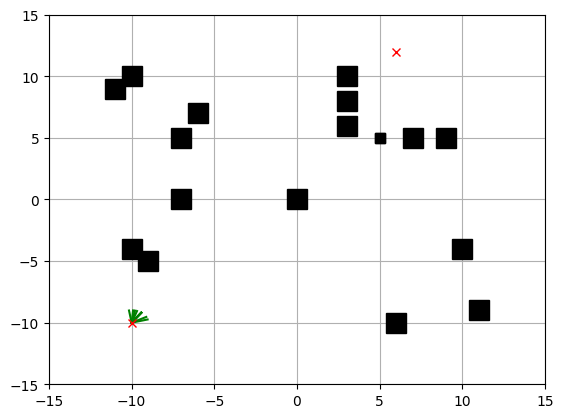

20.19756605276856 [[21916.28261084]]
20.19756605276856 [[21916.28261084]]
19.446398163683188 [[16975.00431635]]
20.95090339179441 [[17336.77783654]]
22.53260536032405 [[17746.17040434]]
21.75109015813456 [[27734.87623685]]
23.372594457583162 [[34267.75557715]]
18.196831821785224 [[1978.88326383]]
13.598977269921981 [[2004.72085476]]
3.4458928041216472 [[210.59296113]]
4.204643695692139 [[113.13528917]]
15.789055021923602 [[3019.838807]]
17.209055417098288 [[1805.36635739]]
20.721040387036897 [[36870.50012073]]
16.391801710706215 [[23719.42087957]]
21.307293599783726 [[40482.50599041]]
13.15584183730073 [[9858.22188819]]
8.831042085074136 [[1368.14419714]]
21.37020891704177 [[23202.90785287]]
21.37020891704177 [[23202.90785287]]
20.78330851982164 [[18007.72043024]]
22.37655624986129 [[18448.51758776]]
24.030701741237642 [[18940.59679656]]
22.821216522624074 [[29368.49385426]]
24.350154372959704 [[36303.31062488]]
20.19111221508641 [[2614.28778751]]
15.490424870581847 [[2363.23799836]]
5

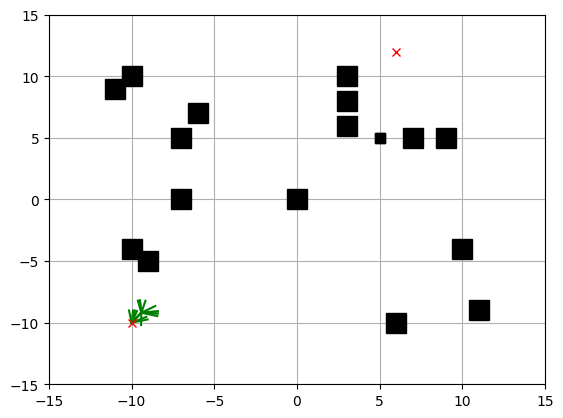

19.96090392502363 [[19203.54397006]]
19.96090392502363 [[19203.54397006]]
19.265328741019143 [[14765.01060204]]
20.804307028910408 [[15107.60115456]]
22.41618813283837 [[15494.63615152]]
21.483845773867525 [[24463.37261433]]
23.07972211632167 [[30389.86792527]]
18.41789499789108 [[1889.08329707]]
13.701460619810282 [[1644.5721044]]
3.5043661504965056 [[116.23514197]]
4.422076432843642 [[113.17165165]]
15.873099711004647 [[2511.52142351]]
17.45928791677581 [[1810.09592089]]
20.266578332094706 [[32711.4580944]]
15.858732971691913 [[20764.02914829]]
20.787674726204937 [[35984.89603524]]
12.902599642773028 [[8364.16264473]]
8.86364905003181 [[1038.0957231]]
19.962560799512815 [[19223.14426277]]
19.962560799512815 [[19223.14426277]]
19.26582681249895 [[14781.74812436]]
20.80411916878281 [[15124.18863336]]
22.415411350422044 [[15511.0735868]]
21.486163696415055 [[24485.76065567]]
23.082604426364952 [[30415.04371525]]
18.411045254460383 [[1887.40036623]]
13.69654895894779 [[1647.44590532]]
3.

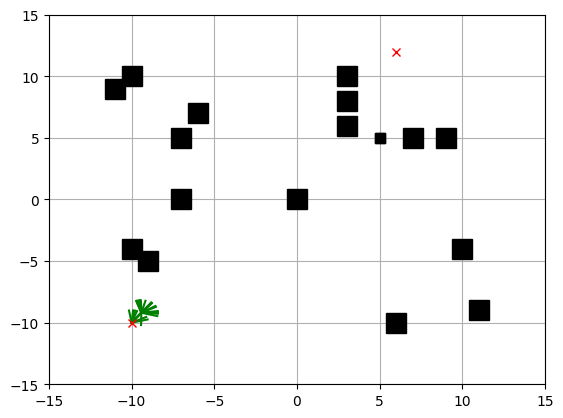

20.0701054081414 [[19913.9061269]]
20.0701054081414 [[19913.9061269]]
19.33930587707235 [[15375.02997902]]
20.856836083718044 [[15713.91253245]]
22.450088441678822 [[16097.23953032]]
21.612703213362906 [[25272.22355148]]
23.22517490319304 [[31297.20764273]]
18.249868819301064 [[1851.50960386]]
13.601848276021277 [[1764.0015794]]
3.4228890353489643 [[155.71583214]]
4.250375819721225 [[101.55395212]]
15.784772430653582 [[2676.48728956]]
17.274500790649142 [[1725.13183708]]
20.519838828774386 [[33684.72819795]]
16.16995944708958 [[21551.44568852]]
21.088303418390066 [[37016.68052669]]
13.021615080937927 [[8837.57284855]]
8.804153990225744 [[1166.79519584]]
19.95383559610941 [[18844.93305503]]
19.95383559610941 [[18844.93305503]]
19.282491927328365 [[14460.2153023]]
20.835528581681615 [[14806.35283758]]
22.459385735782252 [[15196.93481731]]
21.46273498976624 [[24052.71957539]]
23.04652753638407 [[29927.17276242]]
18.58000697094147 [[1929.65576827]]
13.827325320911626 [[1598.21393284]]
3.63

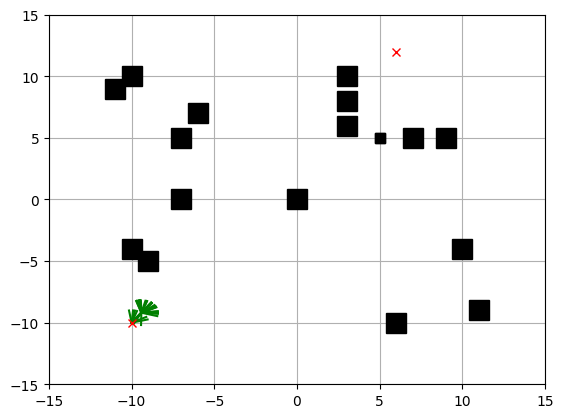

19.68795287108951 [[19042.91101594]]
19.68795287108951 [[19042.91101594]]
18.87668147944941 [[14715.10661372]]
20.346801792555844 [[15015.43598616]]
21.901040676061932 [[15357.43202527]]
21.277534927391798 [[24130.25510439]]
22.931452132791634 [[29842.59919284]]
17.41805254716022 [[1586.57045036]]
12.841630046899231 [[1643.84648525]]
2.733726464820887 [[159.02220126]]
3.427225988007904 [[67.59817659]]
19.17647840420062 [[17316.57700319]]
19.17647840420062 [[17316.57700319]]
18.428992446756254 [[13223.05310179]]
19.94172763157554 [[13525.36944726]]
21.5340948094246 [[13869.35245939]]
20.733288560564105 [[22170.63407732]]
22.360706274276406 [[27649.69115145]]
17.517411072809537 [[1614.85647755]]
12.76502019950216 [[1317.23455842]]
2.567122610654036 [[55.76242363]]
19.14375781811655 [[17104.10357473]]
19.14375781811655 [[17104.10357473]]
18.40894095989718 [[13041.699872]]
19.92948253852422 [[13345.3205334]]
21.52857267079505 [[13690.60786146]]
20.693607781790927 [[21927.69260816]]
22.3151

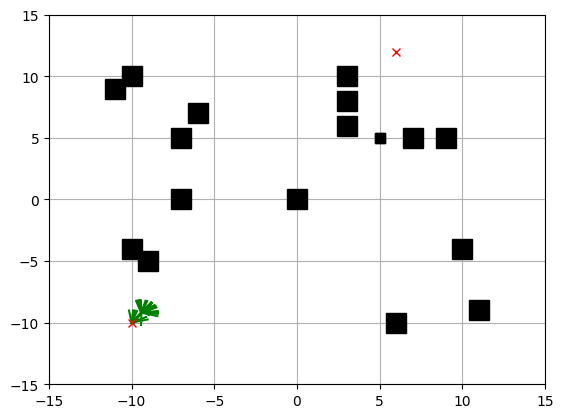

19.14375781811655 [[17104.10357473]]
19.14375781811655 [[17104.10357473]]
18.40894095989718 [[13041.699872]]
19.92948253852422 [[13345.3205334]]
21.52857267079505 [[13690.60786146]]
20.693607781790927 [[21927.69260816]]
22.315181887103172 [[27376.28164159]]
17.582856242953163 [[1634.15414417]]
12.807490996729292 [[1287.56937415]]
2.610373739829939 [[50.0437004]]
19.783488371496432 [[19280.81144524]]
19.783488371496432 [[19280.81144524]]
18.96765736850045 [[14922.82066991]]
20.43429407274465 [[15223.80165013]]
21.98519325487008 [[15566.44929702]]
21.375101691985666 [[24398.66771067]]
23.030491365585807 [[30141.52397611]]
17.451162745491327 [[1597.25857168]]
12.897094671264963 [[1698.67385261]]
2.8079796561030905 [[180.07935273]]
3.467656809948284 [[73.72504346]]
19.14375781811655 [[17104.10357473]]
19.14375781811655 [[17104.10357473]]
18.40894095989718 [[13041.699872]]
19.92948253852422 [[13345.3205334]]
21.52857267079505 [[13690.60786146]]
20.693607781790927 [[21927.69260816]]
22.31518

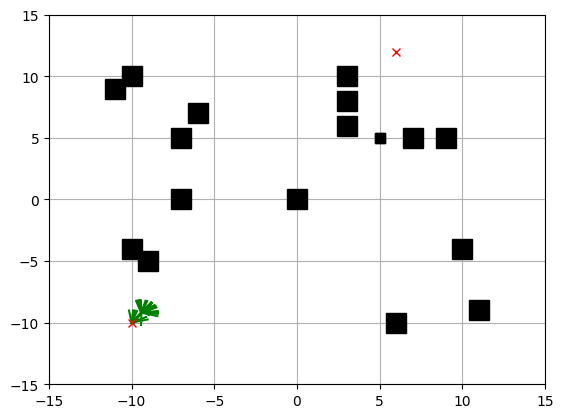

19.458307728378173 [[18400.59644513]]
19.458307728378173 [[18400.59644513]]
18.664176359915842 [[14156.70402454]]
20.146512609380405 [[14456.34199915]]
21.712034944836606 [[14797.64664043]]
21.039611347965135 [[23403.68285304]]
22.68710540581554 [[29031.76926094]]
17.382625587299984 [[1574.45998906]]
12.74318262936276 [[1507.07799772]]
2.5878063827728726 [[109.96838341]]
3.3826372000379217 [[60.3275001]]
19.1699760856334 [[16430.61584642]]
19.1699760856334 [[16430.61584642]]
18.49338252611601 [[12474.31902042]]
20.047812789124666 [[12786.34818902]]
21.67543305215211 [[13140.04402428]]
20.686361912514457 [[21152.30225672]]
22.279209035046577 [[26498.98866701]]
17.999446898774657 [[1745.95735737]]
13.1477171711717 [[1225.49738465]]
2.979409154289373 [[47.83179804]]
19.120021527929758 [[16733.68484927]]
19.120021527929758 [[16733.68484927]]
18.412073936082308 [[12727.58615009]]
19.94865146758173 [[13034.58734149]]
21.56137574744107 [[13383.25519954]]
20.654735394162714 [[21502.65914414]]


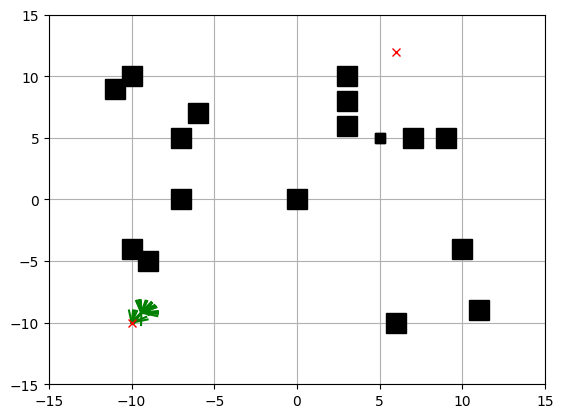

19.968862298668146 [[18760.90373765]]
19.968862298668146 [[18760.90373765]]
19.305306333749193 [[14389.70807673]]
20.862714706579137 [[14737.25258944]]
22.490239598908904 [[15129.24154659]]
21.473124516719775 [[23955.87165493]]
23.052867316625356 [[29817.50623888]]
18.644124534779014 [[1945.2834176]]
13.88228264583601 [[1591.09623396]]
3.6862033327550696 [[102.85019756]]
4.658035385313431 [[134.69405083]]
16.0451111323913 [[2430.56914976]]
17.696173767810645 [[1896.24942482]]
20.126933291603304 [[32084.37322365]]
15.644173894624029 [[20251.80385095]]
20.588060144360337 [[35312.99590051]]
12.903929373031072 [[8071.28932933]]
9.017912216158349 [[972.23495218]]
20.017815036501965 [[18581.74515361]]
20.017815036501965 [[18581.74515361]]
19.372895544736227 [[14240.33239569]]
20.94059732130333 [[14591.44092006]]
22.57671700134215 [[14986.99388887]]
21.510846637843088 [[23748.71217371]]
23.08073064957014 [[29582.34586048]]
18.80650746393079 [[1985.04159155]]
14.024667318278798 [[1579.94303301

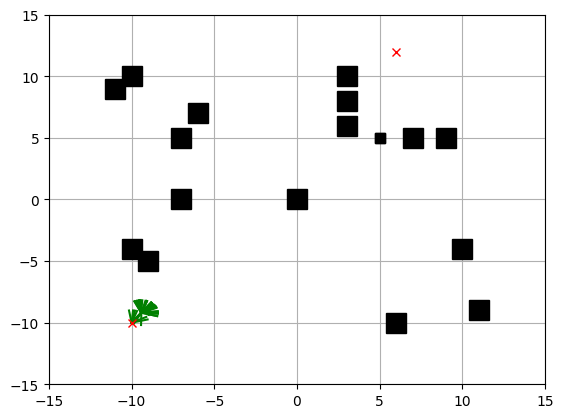

19.13788303216014 [[17055.38474577]]
19.13788303216014 [[17055.38474577]]
18.406210278869292 [[13000.22152947]]
19.928663934493727 [[13304.19584918]]
21.52939190033078 [[13649.83683556]]
20.685987812220883 [[21871.91012192]]
22.30608922653317 [[27313.43549807]]
17.600562613235564 [[1639.29689059]]
12.819883699331829 [[1281.23248887]]
2.6234607543278154 [[49.00218085]]
19.585428101752353 [[18735.99295842]]
19.585428101752353 [[18735.99295842]]
18.783227598893752 [[14448.41665072]]
20.259713017445208 [[14748.65796592]]
21.819768652912742 [[15090.56594778]]
21.17053412374555 [[23783.06492371]]
22.820912256972523 [[29455.13688901]]
17.4122346800796 [[1581.47317337]]
12.805228111764581 [[1578.56116665]]
2.672018572463108 [[134.44929205]]
3.4149068702386476 [[63.11730034]]
19.13788303216014 [[17055.38474577]]
19.13788303216014 [[17055.38474577]]
18.406210278869292 [[13000.22152947]]
19.928663934493727 [[13304.19584918]]
21.52939190033078 [[13649.83683556]]
20.685987812220883 [[21871.91012192

KeyboardInterrupt: 

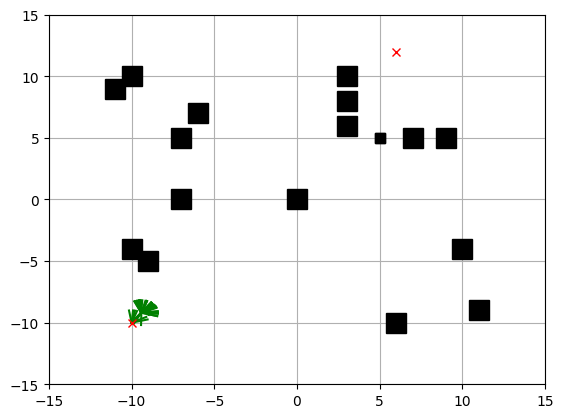

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq

image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]

show_animation = True

def lt(one, two):
        # Define the comparison for the heap based on the sum of g and h values
        return one.first < two.first
class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
    
    # def __lt__(self, other):
    #     # Define the custom comparison for the heap based on the 'first' attribute
    #     return self.first < other.first
        
class CustNode():
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.x < other.x

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []  # Priority queue for nodes to explore
        custNodetemp = CustNode(0, self.start)
        heapq.heappush(open_set, custNodetemp)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes

        while open_set:
            currTemp = heapq.heappop(open_set)
            current_node = currTemp.y
            if current_node == self.end:
                print("Goal!")
                break

            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.expand_dis
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)

                if new_node in closed_set:
                    continue

                
                last_index = self.get_node_index(self.node_list,new_node.parent)
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                sequence_length = len(sequence)
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
                
                custNode = CustNode(new_node.g + new_node.h, new_node)
                # Add the new node to open_set
                heapq.heappush(open_set, custNode)
                self.node_list.append(new_node)

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph()

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
        (5, 5, 0.25),
        (5, 5, 0.25),
        (3, 6, 0.5),
        (3, 8, 0.5),
        (3, 10, 0.5),
        (7, 5, 0.5),
        (9, 5, 0.5),
        (-10, 10, 0.5),
        (-7, 5, 0.5),
        (-9, -5, 0.5),
        (-10, -4, 0.5),
        (-6, 7, 0.5),
        (-11, 9, 0.5),
        (10, -4, 0.5),
        (6, -10, 0.5),
        (11, -9, 0.5),
        (0, 0, 0.5),
        (-7, 0, 0.5)
    ]

    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    rrt.Astar(animation=True)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in rrt.node_list:
          if node.parent is not None:
            plt.plot([node.x, rrt.node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(-10, -10, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq

image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]

show_animation = True

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
    
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.g + self.h < other.h +other.g 

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=1, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []
        heapq.heappush(open_set, self.start)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes
        # path = [[self.start.x,self.start.y]]
        # sequence_length = 0
        while open_set:
            current_node = heapq.heappop(open_set)
            # current_node = currTemp.y
            if current_node == self.end:
                print("Goal!")
                path = []
                while current_node:
                    path.append([current_node.x, current_node.y])
                    current_node = current_node.parent
                path.reverse()
                return path

            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.expand_dis
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)

                
                
                sequence.append([self.start.x, self.start.y])
                # last_node = current_node
                # while last_node.parent :
                #     node = last_node
                #     sequence.append([node.x, node.y])
                #     last_node= node.parent
                sequence_length = len(sequence)
                # print(sequence_length)
                # print("\n\n")
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
                # path.append(new_node)
                # Add the new node to open_set
                if new_node not in closed_set:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph(sequence_length,rnd)
        return None  # Failed to find the path
    
    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True


    def draw_graph(self, sequence_length, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
            ox += sequence_length*move_obs[0]
            oy += sequence_length*move_obs[1]
            x_o = np.array([ox,oy])
            x,y = draw_cov(x_o, cov_obs, p=0.95)
            # plt.plot(x,y,'-b')
            plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        # plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
    (5, 5, 0.25),
    (3, 6, 0.5),
    (3, 8, 0.5),
    (3, 10, 0.5),
    (7, 5, 0.5),
    (9, 5, 0.5),
    (-10, 10, 0.5),
    (-7, 5, 0.5),
    (-9, -5, 0.5),
    (-10, -4, 0.5),
    (-6, 7, 0.5),
    (-11, 9, 0.5),
    (10, -4, 0.5),
    (6, -10, 0.5),
    (11, -9, 0.5),
    (0, 0, 0.5),
    (-7, 0, 0.5)]

    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path = rrt.Astar(animation=False)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
        # length_path = len(path)
        path = path[::-1]
        print(path.shape)

        i = 1
        for (x,y) in path:

            plt.clf()

            for node in rrt.node_list:
                if node.parent is not None:
                    plt.plot([node.x, rrt.node_list[node.parent].x], [node.y, rrt.node_list[node.parent].y], "-g")

            x_f = np.array([x,y])
            cov_robo = cov_rob*(i-1)
            xf,yf = draw_cov(x_f, cov_robo, p=0.95)
            plt.plot(xf,yf,'--m')
            plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

            for (ox, oy, size) in obstacleList:
                ox += i*move_obs[0]
                oy += i*move_obs[1]
                x_o = np.array([ox,oy])
                x,y = draw_cov(x_o, cov_obs, p=0.95)
                # plt.plot(x,y,'-b')
                plt.plot(ox, oy, "s", color='black', markersize=size*30)

            plt.grid(True)
            plt.axis([-15, 15, -15, 15])
            plt.plot(-10, -10, "xr")
            plt.plot(gx, gy, "xr")
            plt.pause(0.5)
            # plt.savefig('image%04d'%image_counter)
            # image_counter += 1
            i = i + 1

if __name__ == '__main__':
	main()



KeyboardInterrupt: 